# Decision tree algorithm

In [1]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import (roc_curve, auc, roc_auc_score,
                             confusion_matrix, precision_score, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Loading data:
df = pd.read_csv('dev.csv')

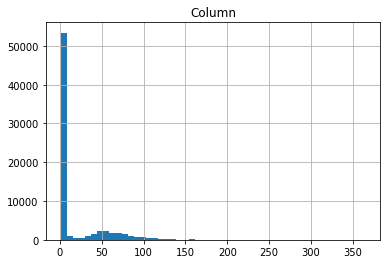

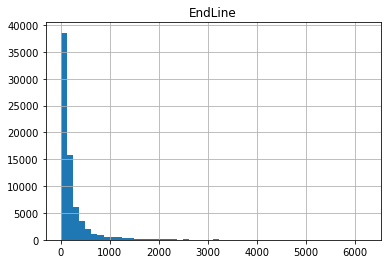

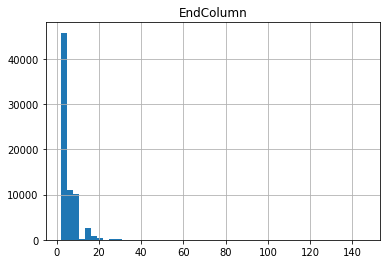

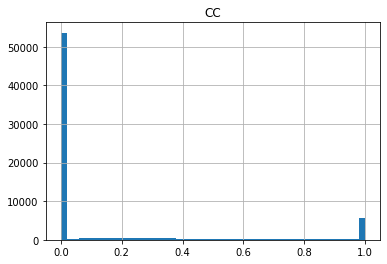

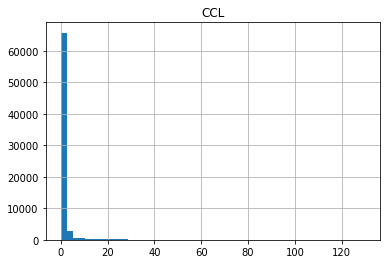

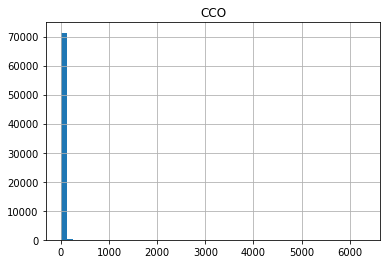

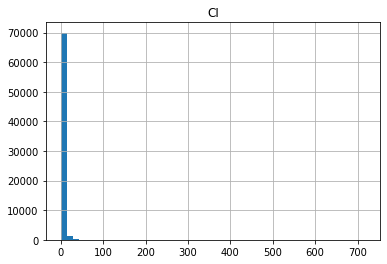

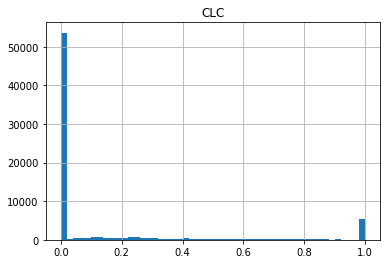

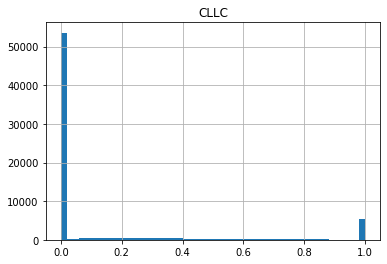

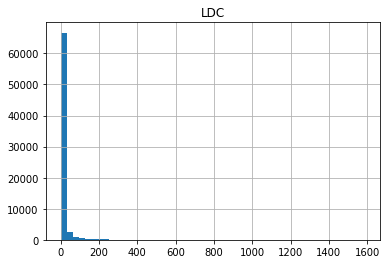

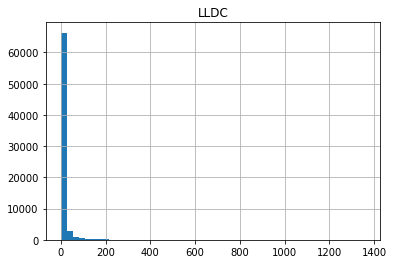

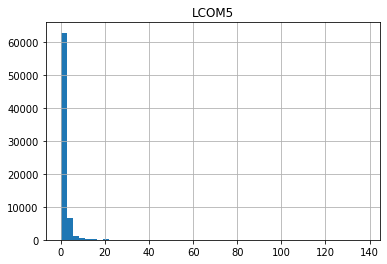

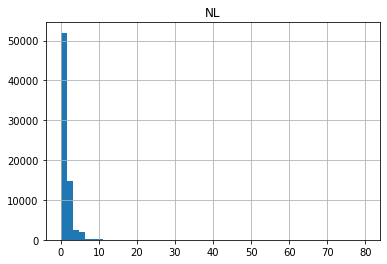

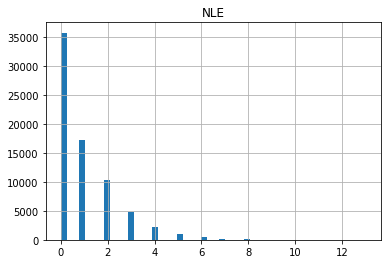

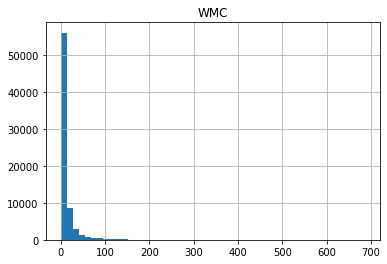

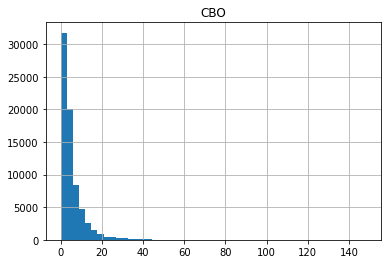

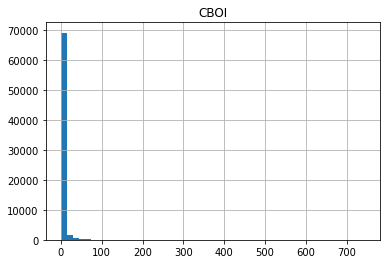

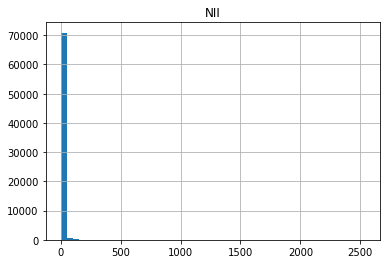

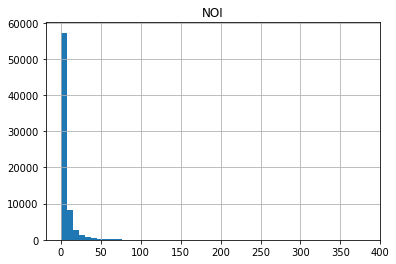

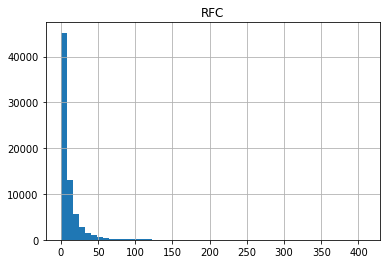

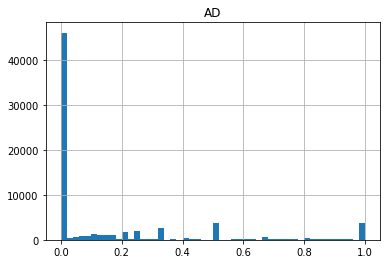

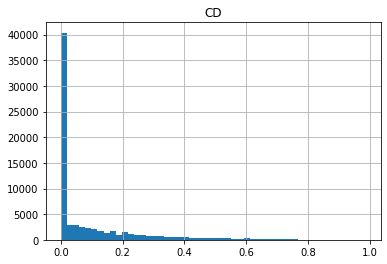

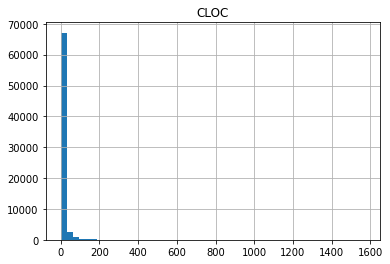

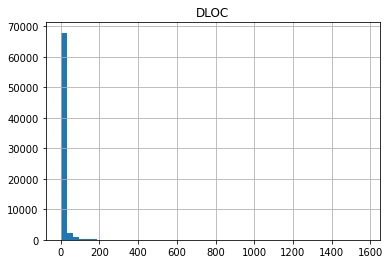

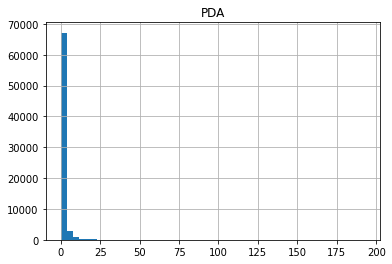

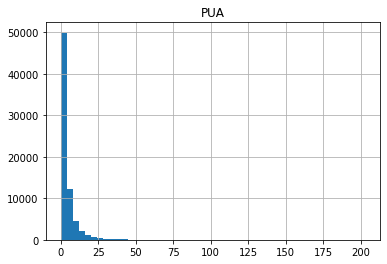

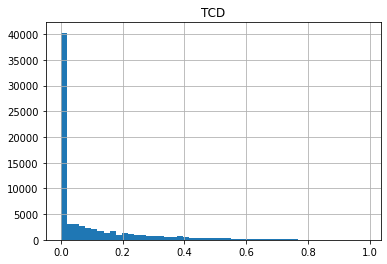

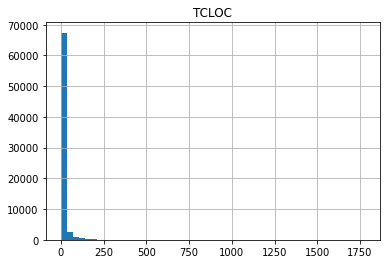

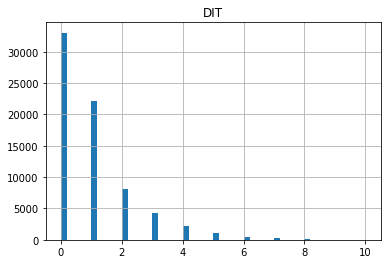

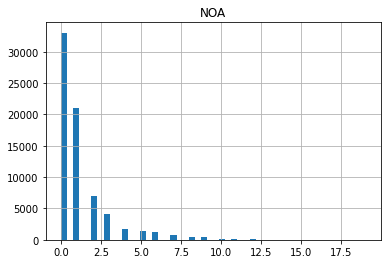

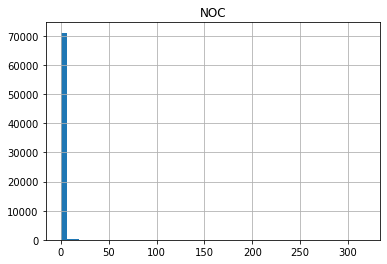

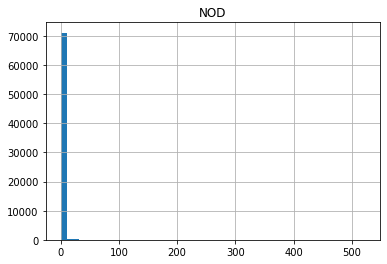

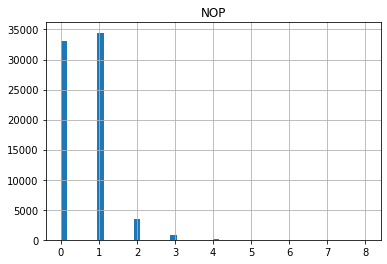

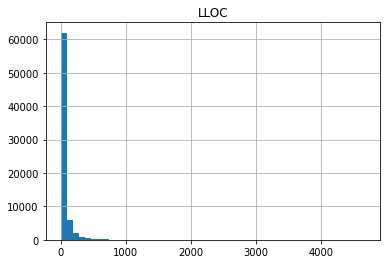

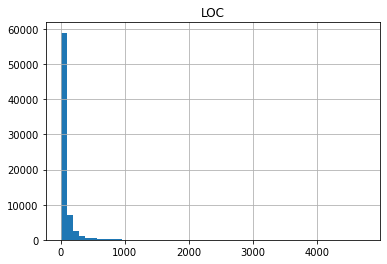

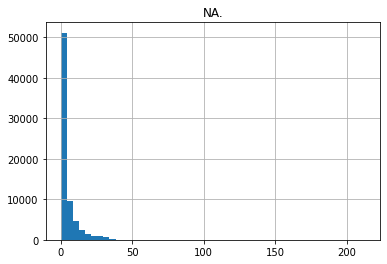

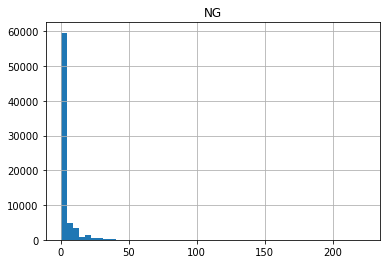

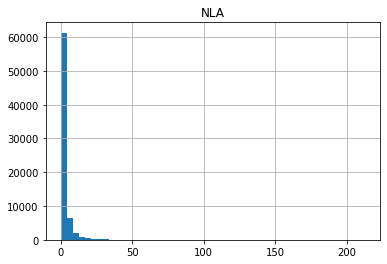

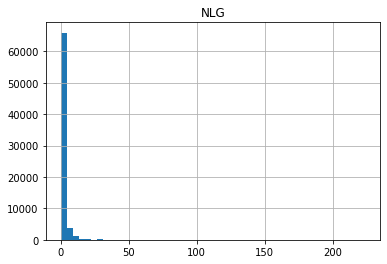

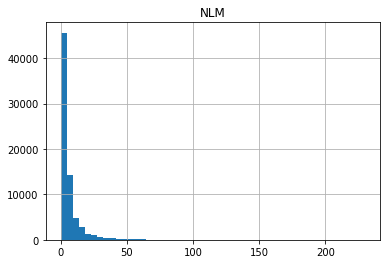

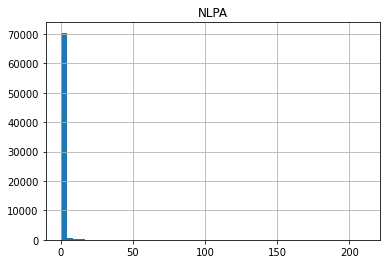

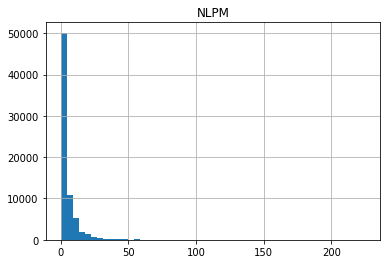

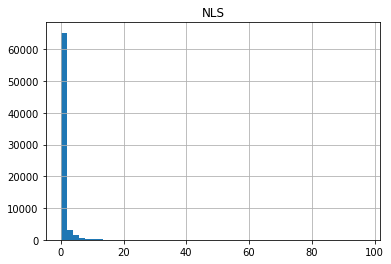

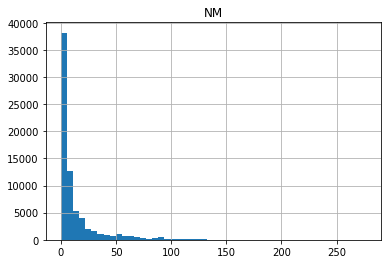

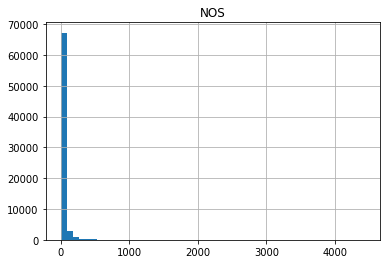

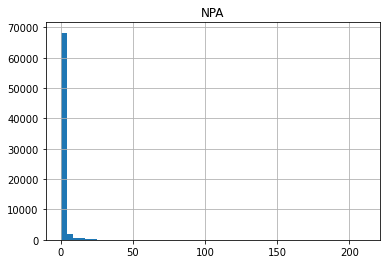

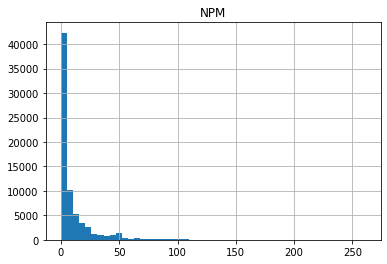

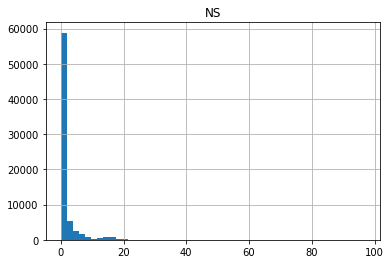

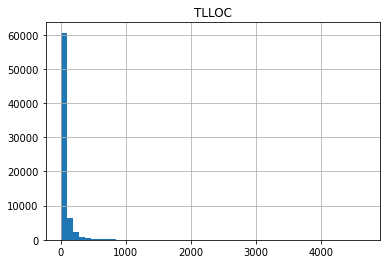

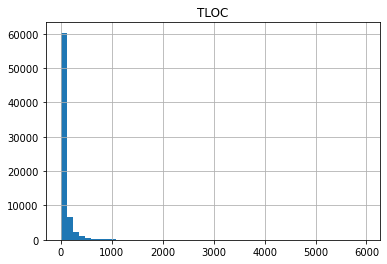

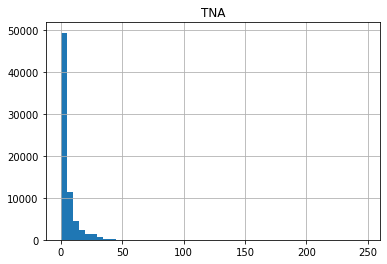

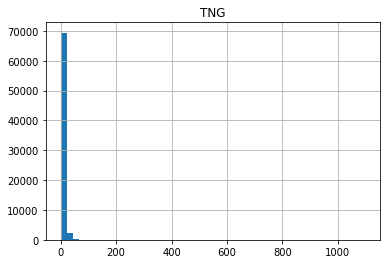

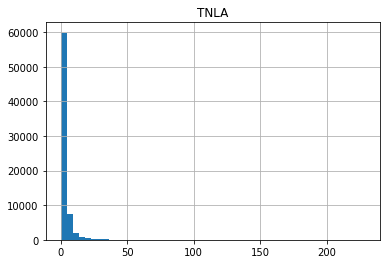

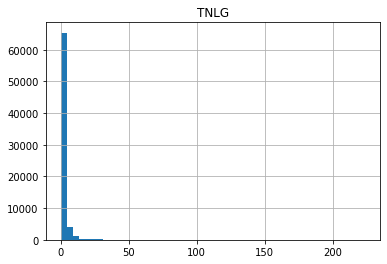

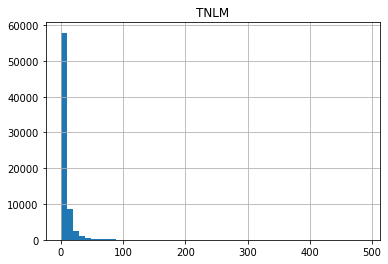

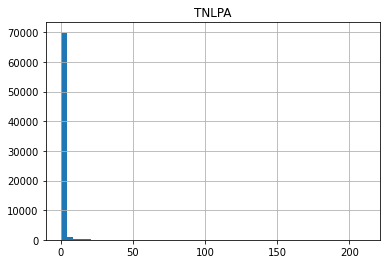

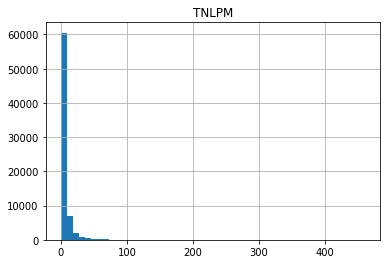

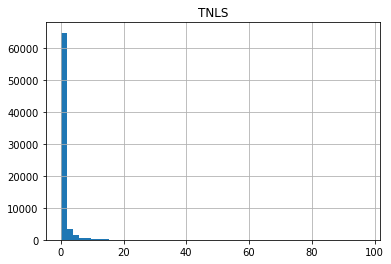

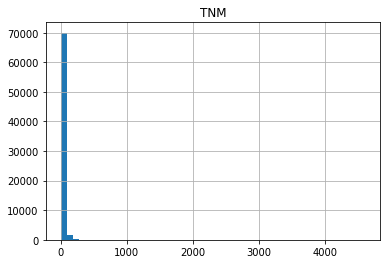

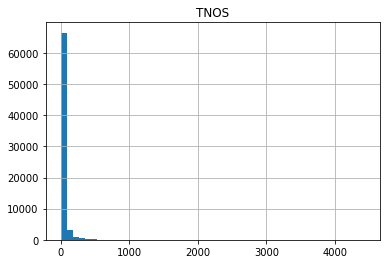

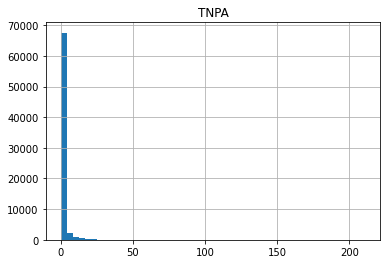

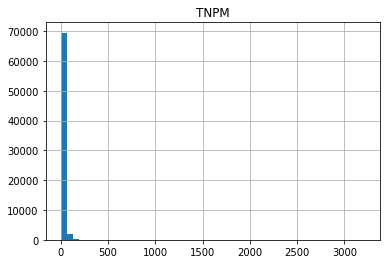

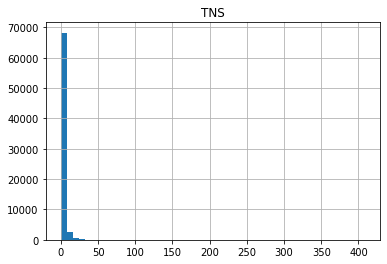

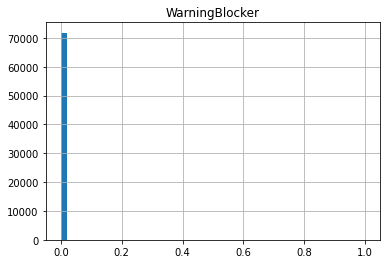

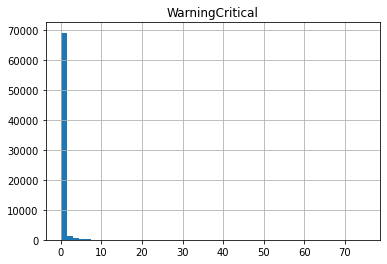

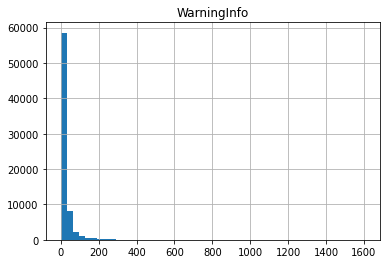

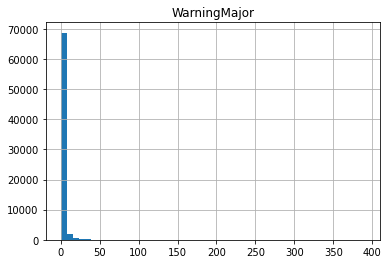

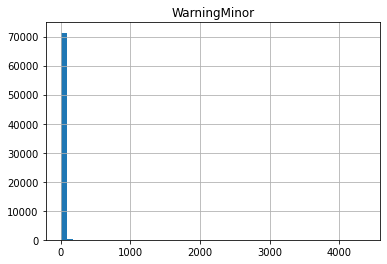

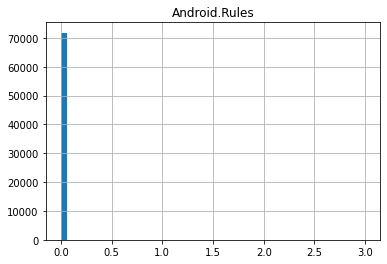

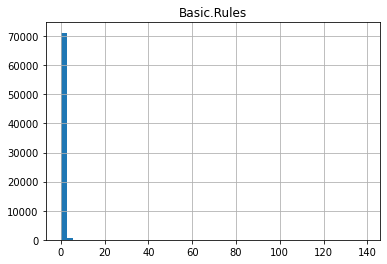

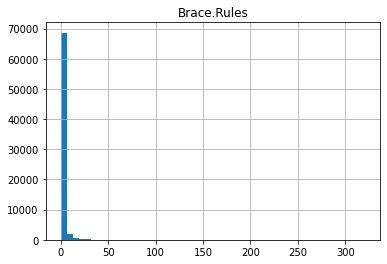

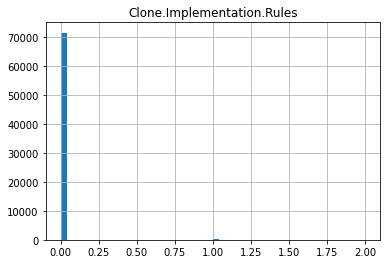

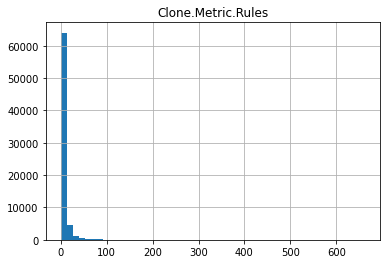

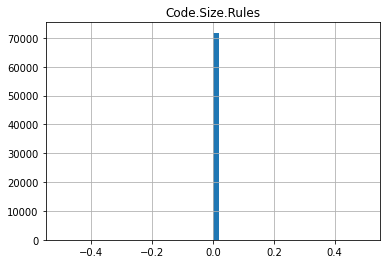

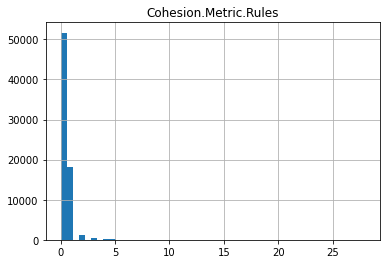

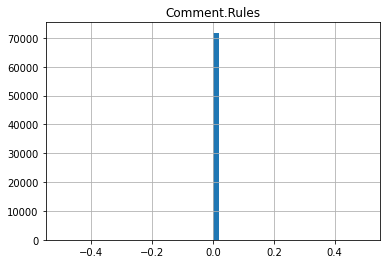

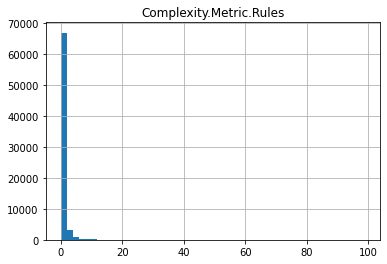

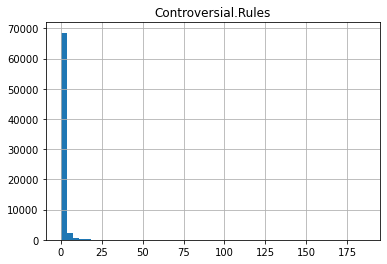

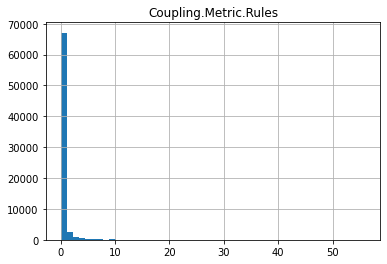

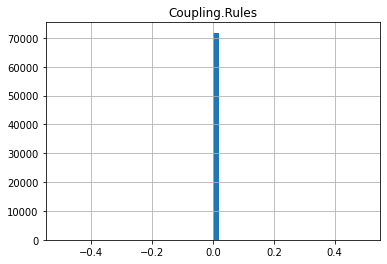

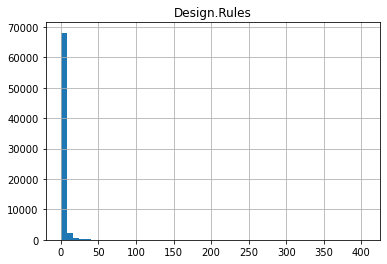

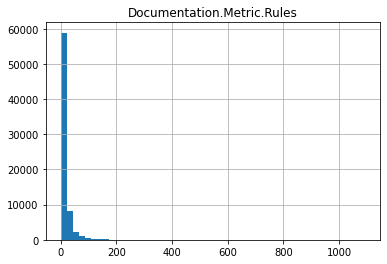

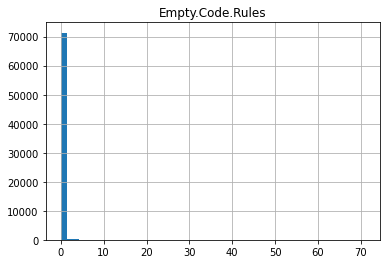

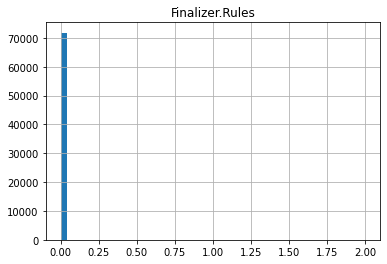

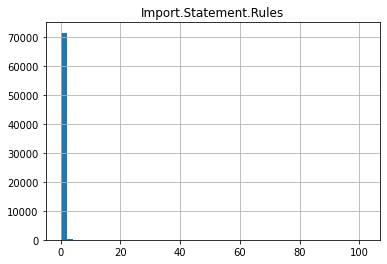

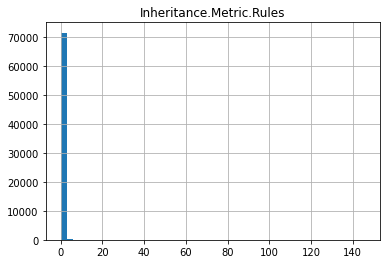

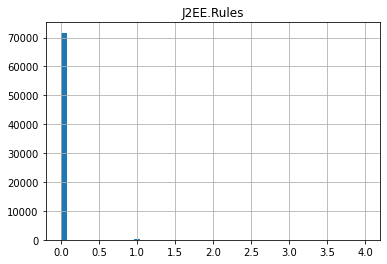

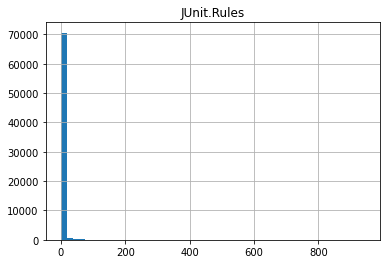

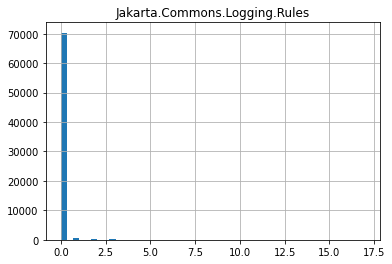

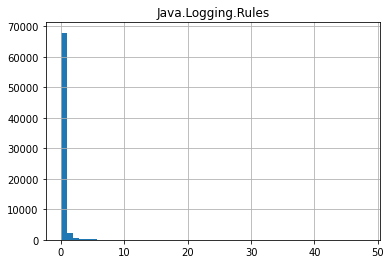

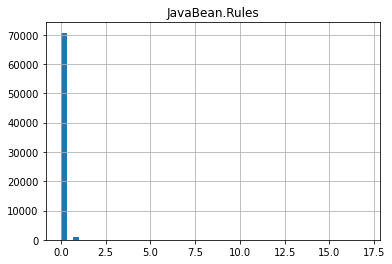

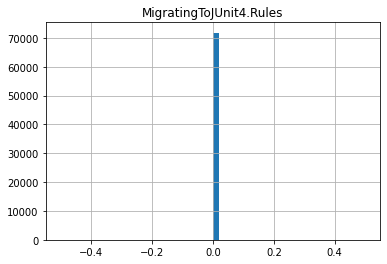

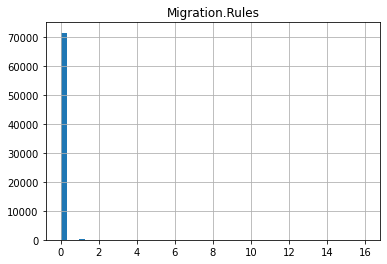

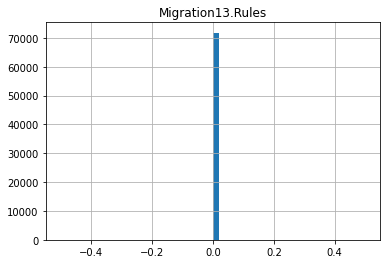

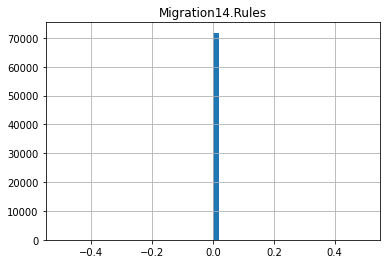

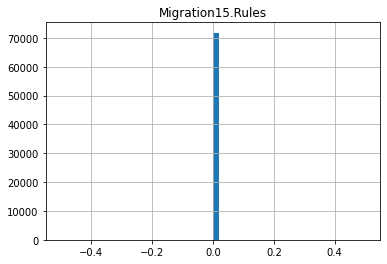

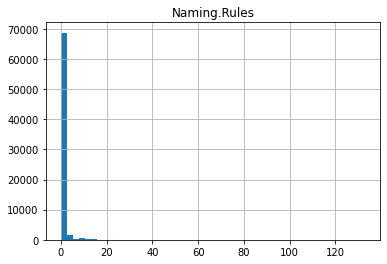

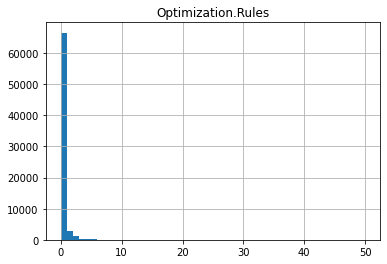

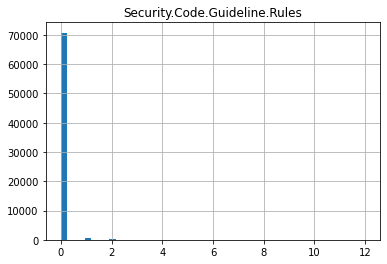

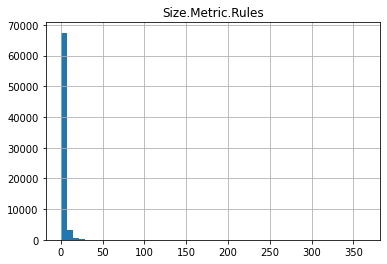

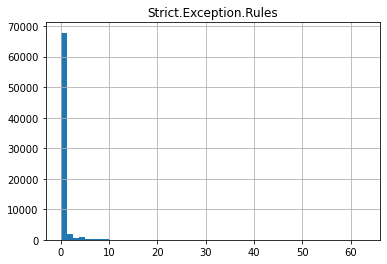

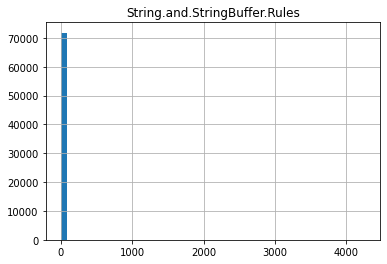

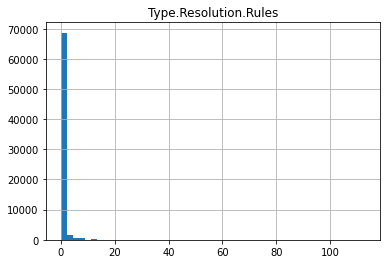

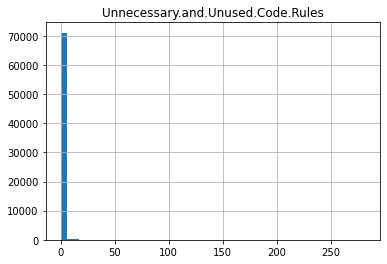

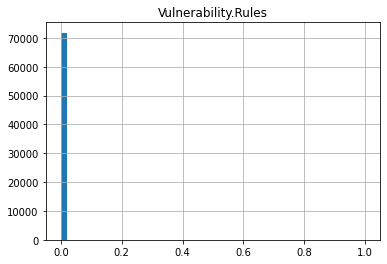

In [4]:
df_explore = df.copy().iloc[:, 4:]
df_explore = df_explore.iloc[:,:-1]
for column in df_explore:
    df_explore[column].hist(bins=50)
    plt.title(column)
    plt.show()

In [5]:
df.bugs.value_counts(True)

False    0.954155
True     0.045845
Name: bugs, dtype: float64

<p>95,42% of the data represents codes where bugs = False</p> <br />
<p>4,58% of the data represents codes where bugs = True</p><br />

In that way, it is important to use some strategies for split data (Stratified Shuffle Split), SMOTE (Oversampling and Undersampling) ...

In [6]:
df = df.iloc[:, 4:] # Drop columns with ID ...
df = df.drop_duplicates()
df = df.dropna()

In [7]:
#Split features and target
df_copy = df.copy()
df_copy.bugs = [0 if (i == False) else 1 for i in df_copy.iloc[:,-1]]

# Features
X = df_copy.iloc[:,:-1].to_numpy()

# Targets
targets = df_copy.bugs
y = pd.DataFrame({"bugs": targets})
y = y.to_numpy()

In [8]:
# Stratified split given the target y
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
X_train

array([[5.000e+01, 3.650e+02, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 6.900e+01, 2.000e+00, ..., 2.000e+00, 0.000e+00,
        0.000e+00],
       [6.200e+01, 6.630e+02, 1.800e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 4.100e+01, 2.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 1.311e+03, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.500e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

##### Checking if Stratified Split worked

training dataset

In [10]:
y_train_check = pd.DataFrame(y_train, columns=["bugs"])
y_train_check.bugs.value_counts(True)

0    0.937141
1    0.062859
Name: bugs, dtype: float64

testing dataset

In [11]:
y_test_check = pd.DataFrame(y_test, columns=["bugs"])
y_test_check.bugs.value_counts(True)

0    0.937142
1    0.062858
Name: bugs, dtype: float64

##### Standarization

In [12]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Run the Decision tree model

In [13]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [14]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.905192608016658


Classification report:

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     14402
           1       0.24      0.24      0.24       966

    accuracy                           0.91     15368
   macro avg       0.60      0.59      0.59     15368
weighted avg       0.90      0.91      0.90     15368



#### AUC and ROC curve

In [16]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    #Prints the AUC scores for training and testing data and returns testing score
    
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_score)
    auc_test = roc_auc_score(y_test, y_test_score)
    print(f'Training AUC: {auc_train} \nTesting AUC: {auc_test}')

    return y_test_score

In [17]:
result = get_auc_scores(clf, X_train, X_test, y_train, y_test)

Training AUC: 0.9996746647919867 
Testing AUC: 0.5978333826421048


In [18]:
def plot_roc_curve(y_test, y_test_score):
    # Plot ROC curve for testing data

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - (ROC)')
    plt.legend(loc='lower right')
    plt.show()

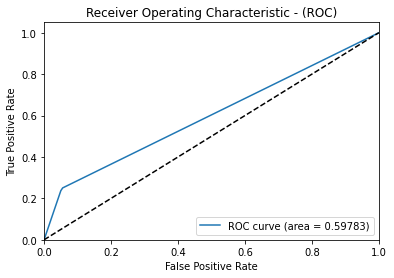

In [19]:
plot_roc_curve(y_test, result)

In [20]:
def show_cm(y_true, y_pred, class_names=None, model_name=None):
    #Show confusion matrix
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title('Confusion Matrix: {}'.format(model_name))
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    else:
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
    if class_names:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    else:
        class_names = set(y_true)
        print(class_names)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        
    thresh = cf.max() / 2.0
    for i, j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j, i, cf[i, j],horizontalalignment='center',color='white' if cf[i, j] > thresh else 'black')
    plt.colorbar()

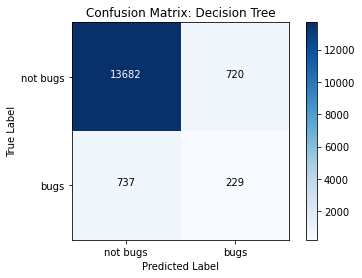

In [21]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "Decision Tree")

The above example shows a big disparity between training and testing results. Due to it, the cross validation method will be implemented, meaning that we are going to split our test data and then predict the same model within that data, to improve our classification model.

##### Oversampling

In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = RANDOM_SEED)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_res, y_train_res)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
result = get_auc_scores(clf, X_train_res, X_test, y_train_res, y_test)

In [ ]:
plot_roc_curve(y_test, result)

In [ ]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "Decision Tree")

##### Undersampling

In [ ]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler

nr = RandomUnderSampler(sampling_strategy=0.5)
  
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_miss, y_train_miss)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

what if the model guesses otherwise?

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
result = get_auc_scores(clf, X_train_miss, X_test, y_train_miss, y_test)

In [ ]:
plot_roc_curve(y_test, result)

In [ ]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "Decision Tree")

##### Oversampling + Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline

counter = Counter(y_train[:,0])
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.15)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_under_over, y_train_under_over = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train_under_over)
print(counter)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_under_over, y_train_under_over)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
result = get_auc_scores(clf, X_train_under_over, X_test, y_train_under_over, y_test)

In [ ]:
plot_roc_curve(y_test, result)

In [ ]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "Decision Tree")

# SGD classifier

In [ ]:
# Existe aleatoriedade dentro do SGDClassifier, por isso o argumento
# random_state=RANDOM_SEED.
sgd_clf = SGDClassifier(
    max_iter=500,
    tol=1e-3,
    random_state=RANDOM_SEED,
    loss="hinge"
)

clf = CalibratedClassifierCV(sgd_clf)
clf = clf.fit(X_train, y_train.ravel())

In [ ]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    #Prints the AUC scores for training and testing data and returns testing score
    
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_score)
    auc_test = roc_auc_score(y_test, y_test_score)
    print(f'Training AUC: {auc_train} \nTesting AUC: {auc_test}')

    return y_test_score

In [ ]:
result = get_auc_scores(clf, X_train, X_test, y_train, y_test)

In [ ]:
plot_roc_curve(y_test, result)

In [ ]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "SGD")

##### Undersampling and Oversampling

In [ ]:
counter = Counter(y_train[:,0])
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.15)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_under_over, y_train_under_over = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train_under_over)
print(counter)

In [ ]:
sgd_clf = SGDClassifier(
    max_iter=500,
    tol=1e-3,
    random_state=RANDOM_SEED,
    loss="hinge"
)

clf = CalibratedClassifierCV(sgd_clf)
clf = clf.fit(X_train_under_over, y_train_under_over.ravel())

In [ ]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    #Prints the AUC scores for training and testing data and returns testing score
    clf = CalibratedClassifierCV(clf)
    clf = clf.fit(X_train, y_train.ravel())
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_score)
    auc_test = roc_auc_score(y_test, y_test_score)
    print(f'Training AUC: {auc_train} \nTesting AUC: {auc_test}')

    return y_test_score

In [ ]:
result = get_auc_scores(clf, X_train_under_over, X_test, y_train_under_over, y_test)

In [ ]:
plot_roc_curve(y_test, result)

In [ ]:
show_cm(y_test, y_pred, ["not bugs", "bugs"], "SGD")

That one seems to be the best!

## Submission

In [ ]:
df_comp = pd.read_csv("comp.csv")

In [ ]:
dfinal = {"Id": df_comp.index, "Predicted": []}
df_comp = df_comp.iloc[:,4:]
df_comp

In [ ]:
df_comp=df_comp.iloc[:,:].to_numpy()
sc_X = StandardScaler()
comp = sc_X.fit_transform(df_comp)

In [ ]:
y_pred_prob = clf.predict_proba(comp)

In [ ]:
for i in y_pred_prob:
    dfinal["Predicted"].append(i[1])

In [ ]:
dfinal = pd.DataFrame(dfinal)
dfinal